In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Định nghĩa các hàm
def read_label_file(label_path, img_width, img_height):
    """Đọc file nhãn và chuyển đổi tọa độ."""
    if not os.path.exists(label_path):
        return None, None

    with open(label_path, 'r') as f:
        lines = f.readlines()

    if not lines:  # Background
        return 5, [0, 0, 0, 0]

    class_id, center_x, center_y, width, height = map(float, lines[0].strip().split())
    x_min = (center_x - width / 2) * img_width
    y_min = (center_y - height / 2) * img_height
    x_max = (center_x + width / 2) * img_width
    y_max = (center_y + height / 2) * img_height
    return int(class_id), [x_min, y_min, x_max, y_max]

In [3]:
def load_data(base_dir='/content/drive/MyDrive/BBox', img_size=224):
    """Load dữ liệu từ thư mục img và labels."""
    img_dir = os.path.join(base_dir, 'img')
    label_dir = os.path.join(base_dir, 'labels')

    X, labels, boxes = [], [], []
    class_names = ['Bowl', 'Chopsticks', 'Glass', 'Knife', 'Spoon', 'Background']
    label_encoder = LabelEncoder()
    label_encoder.fit(class_names)

    for img_name in tqdm(os.listdir(img_dir)):
        if not img_name.endswith('.jpg'):
            continue
        img_path = os.path.join(img_dir, img_name)
        label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Không thể đọc ảnh: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_height, img_width = img.shape[:2]
        img = cv2.resize(img, (img_size, img_size))

        class_id, bbox = read_label_file(label_path, img_width, img_height)
        if class_id is None:
            continue

        if class_id != 5:  # Không phải Background
            # Chuyển từ định dạng YOLO (center_x, center_y, width, height) sang [x_min, y_min, x_max, y_max]
            x_min = bbox[0] - bbox[2] / 2
            y_min = bbox[1] - bbox[3] / 2
            x_max = bbox[0] + bbox[2] / 2
            y_max = bbox[1] + bbox[3] / 2
            if x_min >= x_max or y_min >= y_max:
                print(f"Tọa độ không hợp lệ trong {label_path}: x_min={x_min}, x_max={x_max}, y_min={y_min}, y_max={y_max}")
                continue
            # Đảm bảo tọa độ nằm trong [0, 1]
            bbox = [
                max(0, min(x_min, 1.0)),
                max(0, min(y_min, 1.0)),
                max(0, min(x_max, 1.0)),
                max(0, min(y_max, 1.0))
            ]
        else:
            bbox = [0, 0, 0, 0]

        X.append(img)
        labels.append(class_id)
        boxes.append(bbox)

    # Chia dữ liệu thành train, val, test
    X_train, X_temp, labels_train, labels_temp, boxes_train, boxes_temp = train_test_split(
        X, labels, boxes, test_size=0.3, random_state=42
    )
    X_val, X_test, labels_val, labels_test, boxes_val, boxes_test = train_test_split(
        X_temp, labels_temp, boxes_temp, test_size=0.5, random_state=42
    )

    return (X_train, labels_train, boxes_train), (X_val, labels_val, boxes_val), (X_test, labels_test, boxes_test), label_encoder

In [4]:
def get_transforms(img_size=224):
    """Định nghĩa các phép biến đổi ảnh."""
    return {
        "train": transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(60),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3),
            transforms.RandomAffine(degrees=0, translate=(0.3, 0.3), scale=(0.7, 1.3)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        "test": transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

In [5]:
class LocalizationDataset(Dataset):
    """Dataset tùy chỉnh."""
    def __init__(self, images, labels, boxes, transform=None):
        self.images = images
        self.labels = labels
        self.boxes = boxes
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        box = self.boxes[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, box

def get_data_loaders(base_dir='/content/drive/MyDrive/BBox', batch_size=32, img_size=224):
    """Tạo DataLoader cho các tập dữ liệu."""
    transforms = get_transforms(img_size)

    # Load dữ liệu
    (X_train, y_train, boxes_train), (X_val, y_val, boxes_val), (X_test, y_test, boxes_test), label_encoder = load_data(base_dir, img_size)

    train_dataset = LocalizationDataset(X_train, torch.tensor(y_train, dtype=torch.long), torch.tensor(boxes_train, dtype=torch.float32), transform=transforms["train"])
    val_dataset = LocalizationDataset(X_val, torch.tensor(y_val, dtype=torch.long), torch.tensor(boxes_val, dtype=torch.float32), transform=transforms["val"])
    test_dataset = LocalizationDataset(X_test, torch.tensor(y_test, dtype=torch.long), torch.tensor(boxes_test, dtype=torch.float32), transform=transforms["test"])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, label_encoder

In [6]:
class ResNet18TwoBranch(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNet18TwoBranch, self).__init__()
        resnet18 = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet18.children())[:-2])

        self.new_conv_block = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        self.conv = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        # Tăng kích thước và chiều sâu của các nhánh
        self.cls_branch = nn.Sequential(
            nn.Linear(256, 512),  # Tăng từ 256 lên 512 neuron
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # Tăng từ 128 lên 256 neuron
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),  # Thêm một tầng trung gian
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        self.loc_branch = nn.Sequential(
            nn.Linear(256, 512),  # Tăng từ 256 lên 512 neuron
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),  # Tăng từ 128 lên 256 neuron
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),  # Thêm một tầng trung gian
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.new_conv_block(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)

        class_output = self.cls_branch(x)
        loc_output = torch.sigmoid(self.loc_branch(x))
        return class_output, loc_output

In [7]:
def calculate_iou(boxes_pred, boxes_target, labels):
    mask = labels != 5
    if not mask.any():
        return torch.tensor(0.0).to(boxes_pred.device)

    boxes_pred = boxes_pred[mask]
    boxes_target = boxes_target[mask]

    x1, y1, x2, y2 = boxes_pred[:, 0], boxes_pred[:, 1], boxes_pred[:, 2], boxes_pred[:, 3]
    x1_gt, y1_gt, x2_gt, y2_gt = boxes_target[:, 0], boxes_target[:, 1], boxes_target[:, 2], boxes_target[:, 3]

    # Đảm bảo x2 >= x1 và y2 >= y1
    x1 = torch.min(x1, x2)
    y1 = torch.min(y1, y2)
    x2 = torch.max(x1, x2)
    y2 = torch.max(y1, y2)
    x1_gt = torch.min(x1_gt, x2_gt)
    y1_gt = torch.min(y1_gt, y2_gt)
    x2_gt = torch.max(x1_gt, x2_gt)
    y2_gt = torch.max(y1_gt, y2_gt)

    x1_inter = torch.max(x1, x1_gt)
    y1_inter = torch.max(y1, y1_gt)
    x2_inter = torch.min(x2, x2_gt)
    y2_inter = torch.min(y2, y2_gt)

    inter_area = torch.clamp(x2_inter - x1_inter, min=0) * torch.clamp(y2_inter - y1_inter, min=0)
    area_pred = (x2 - x1) * (y2 - y1)
    area_target = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    union_area = area_pred + area_target - inter_area
    iou = inter_area / union_area.clamp(min=1e-6)
    return iou.mean()

In [19]:
def train_model(model, train_loader, val_loader, num_epochs=500, img_size=224, base_dir='/content/drive/MyDrive/BBox'):
    criterion_cls = nn.CrossEntropyLoss()
    criterion_loc = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)  # Giảm từ 1e-4 xuống 1e-5
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    lambda_loc = 5.0
    best_val_loss = float('inf')
    patience = 30
    counter = 0

    # Khởi tạo danh sách để lưu các giá trị loss và accuracy
    train_losses = []
    train_losses_cls = []
    train_losses_loc = []
    train_accs = []
    train_ious = []

    val_losses = []
    val_accs = []
    val_ious = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_loss_cls = 0.0
        running_loss_loc = 0.0
        correct = 0
        total = 0
        iou_sum = 0.0
        iou_count = 0

        for images, labels, boxes in train_loader:
            images, labels, boxes = images.to(device), labels.to(device), boxes.to(device)

            optimizer.zero_grad()

            class_output, loc_output = model(images)

            loss_cls = criterion_cls(class_output, labels)

            mask = labels != 5
            if mask.any():
                loss_loc = criterion_loc(loc_output[mask], boxes[mask])
            else:
                loss_loc = torch.tensor(0.0).to(device)

            loss = loss_cls + lambda_loc * loss_loc

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_loss_cls += loss_cls.item()
            running_loss_loc += loss_loc.item() if mask.any() else 0

            _, predicted = torch.max(class_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            iou = calculate_iou(loc_output, boxes, labels)
            if iou > 0:
                iou_sum += iou.item()
                iou_count += 1

        train_loss = running_loss / len(train_loader)
        train_loss_cls = running_loss_cls / len(train_loader)
        train_loss_loc = running_loss_loc / len(train_loader)
        train_acc = 100 * correct / total
        train_iou = iou_sum / max(iou_count, 1)

        # Lưu các metrics
        train_losses.append(train_loss)
        train_losses_cls.append(train_loss_cls)
        train_losses_loc.append(train_loss_loc)
        train_accs.append(train_acc)
        train_ious.append(train_iou)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_iou_sum = 0.0
        val_iou_count = 0

        with torch.no_grad():
            for images, labels, boxes in val_loader:
                images, labels, boxes = images.to(device), labels.to(device), boxes.to(device)

                class_output, loc_output = model(images)

                loss_cls = criterion_cls(class_output, labels)

                mask = labels != 5
                if mask.any():
                    loss_loc = criterion_loc(loc_output[mask], boxes[mask])
                else:
                    loss_loc = torch.tensor(0.0).to(device)

                loss = loss_cls + lambda_loc * loss_loc

                val_loss += loss.item()

                _, predicted = torch.max(class_output, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                iou = calculate_iou(loc_output, boxes, labels)
                if iou > 0:
                    val_iou_sum += iou.item()
                    val_iou_count += 1

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_iou = val_iou_sum / max(val_iou_count, 1)

        # Lưu metrics
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_ious.append(val_iou)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f} (Cls: {train_loss_cls:.4f}, Loc: {train_loss_loc:.4f}), Train Acc: {train_acc:.2f}%, Train IoU: {train_iou:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val IoU: {val_iou:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), os.path.join(base_dir, 'bestmodel/resnet18_two_branch.pth'))
        else:
            counter += 1

        # Vẽ biểu đồ sau mỗi 10 epoch hoặc epoch cuối
        if (epoch + 1) % 10 == 0 or epoch == num_epochs - 1:
            plot_training_metrics(train_losses, val_losses, train_accs, val_accs, train_ious, val_ious, train_losses_cls, train_losses_loc, epoch + 1, base_dir)

        if counter >= patience:
            print("Early stopping triggered")
            break

    # Vẽ biểu đồ cuối cùng
    plot_training_metrics(train_losses, val_losses, train_accs, val_accs, train_ious, val_ious, train_losses_cls, train_losses_loc, num_epochs, base_dir)

    return train_losses, val_losses, train_accs, val_accs, train_ious, val_ious

In [9]:
def plot_training_metrics(train_losses, val_losses, train_accs, val_accs, train_ious, val_ious, train_losses_cls, train_losses_loc, epoch, base_dir):
    os.makedirs(os.path.join(base_dir, 'plots'), exist_ok=True)

    # Vẽ loss
    plt.figure(figsize=(15, 10))

    # Total Loss
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Component Losses
    plt.subplot(2, 2, 2)
    plt.plot(train_losses_cls, label='Classification Loss')
    plt.plot(train_losses_loc, label='Localization Loss')
    plt.title('Component Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # IoU
    plt.subplot(2, 2, 4)
    plt.plot(train_ious, label='Train IoU')
    plt.plot(val_ious, label='Val IoU')
    plt.title('Intersection over Union (IoU)')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, f'plots/training_metrics_epoch_{epoch}.png'))
    plt.close()

    print(f"Đã lưu biểu đồ metrics tại epoch {epoch}")

In [10]:
def evaluate_model(model, test_loader, label_encoder, img_size=224, base_dir='/content/drive/MyDrive/BBox'):
    model.eval()
    output_file = os.path.join(base_dir, 'detections.txt')
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    test_correct = 0
    test_total = 0
    test_iou_sum = 0.0
    test_iou_count = 0

    images_to_show = []
    predicted_boxes = []
    ground_truth_boxes = []
    predicted_labels = []
    ground_truth_labels = []
    num_images_to_show = 25
    images_collected = 0

    with torch.no_grad():
        with open(output_file, 'w') as f:
            for images, labels, boxes in test_loader:
                images, labels, boxes = images.to(device), labels.to(device), boxes.to(device)
                class_output, loc_output = model(images)

                _, predicted = torch.max(class_output, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

                if images_collected < num_images_to_show:
                    for i in range(len(images)):
                        if images_collected >= num_images_to_show:
                            break
                        img = images[i].cpu().permute(1, 2, 0).numpy()
                        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                        img = np.clip(img, 0, 1)
                        images_to_show.append(img)

                        pred_box = loc_output[i].cpu().numpy() * img_size
                        predicted_boxes.append(pred_box)

                        gt_box = boxes[i].cpu().numpy() * img_size
                        ground_truth_boxes.append(gt_box)

                        pred_label = label_encoder.inverse_transform([predicted[i].cpu().numpy()])[0]
                        gt_label = label_encoder.inverse_transform([labels[i].cpu().numpy()])[0]
                        predicted_labels.append(pred_label)
                        ground_truth_labels.append(gt_label)

                        images_collected += 1

                if test_total <= labels.size(0):
                    print("Sample predicted boxes (first 5):", loc_output[:5].cpu().numpy())
                    print("Sample ground truth boxes (first 5):", boxes[:5].cpu().numpy())

                for i in range(len(predicted)):
                    class_name = label_encoder.inverse_transform([predicted[i].cpu().numpy()])[0]
                    if class_name == 'Background':
                        continue
                    bbox = loc_output[i].cpu().numpy() * img_size
                    x_min, y_min, x_max, y_max = bbox
                    x_min = max(0, min(x_min, img_size))
                    y_min = max(0, min(y_min, img_size))
                    x_max = max(0, min(x_max, img_size))
                    y_max = max(0, min(y_max, img_size))
                    f.write(f"{class_name} {x_min} {y_min} {x_max} {y_max}\n")

        for images, labels, boxes in test_loader:
            images, labels, boxes = images.to(device), labels.to(device), boxes.to(device)
            _, loc_output = model(images)
            iou = calculate_iou(loc_output, boxes, labels)
            if iou > 0:
                test_iou_sum += iou.item()
                test_iou_count += 1

    test_acc = 100 * test_correct / test_total if test_total > 0 else 0
    test_iou = test_iou_sum / max(test_iou_count, 1)

    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Test IoU: {test_iou:.4f}")
    print(f"Bounding boxes đã được lưu vào {output_file}")

    plt.figure(figsize=(20, 20))
    for i in range(num_images_to_show):
        plt.subplot(5, 5, i + 1)
        img = images_to_show[i].copy()

        gt_box = ground_truth_boxes[i]
        x_min, y_min, x_max, y_max = map(int, gt_box)
        if ground_truth_labels[i] != 'Background':
            img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 1, 0), 2)

        pred_box = predicted_boxes[i]
        x_min, y_min, x_max, y_max = map(int, pred_box)
        if predicted_labels[i] != 'Background':
            img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (1, 0, 0), 2)

        plt.imshow(img)
        plt.title(f"Pred: {predicted_labels[i]}\nGT: {ground_truth_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
def create_data_yaml(base_dir='/content/drive/MyDrive/BBox'):
    """Tạo file data.yaml."""
    data_yaml = {
        'train': os.path.join(base_dir, 'img'),
        'val': os.path.join(base_dir, 'img'),
        'test': os.path.join(base_dir, 'img'),
        'nc': 6,
        'names': ['Bowl', 'Chopsticks', 'Glass', 'Knife', 'Spoon', 'Background']
    }
    with open(os.path.join(base_dir, 'data.yaml'), 'w') as f:
        for key, value in data_yaml.items():
            f.write(f"{key}: {value}\n")
    print("Đã tạo file data.yaml!")

Đã tạo file data.yaml!


100%|██████████| 1275/1275 [00:52<00:00, 24.28it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/500, Train Loss: 3.0745 (Cls: 1.7926, Loc: 0.2564), Train Acc: 18.30%, Train IoU: 0.0000, Val Loss: 3.0783, Val Acc: 29.86%, Val IoU: 0.0000
Epoch 2/500, Train Loss: 3.0477 (Cls: 1.7813, Loc: 0.2533), Train Acc: 25.15%, Train IoU: 0.0000, Val Loss: 3.0398, Val Acc: 25.69%, Val IoU: 0.0000
Epoch 3/500, Train Loss: 3.0206 (Cls: 1.7718, Loc: 0.2498), Train Acc: 28.42%, Train IoU: 0.0000, Val Loss: 2.9891, Val Acc: 25.00%, Val IoU: 0.0000
Epoch 4/500, Train Loss: 2.9823 (Cls: 1.7562, Loc: 0.2452), Train Acc: 34.23%, Train IoU: 0.0001, Val Loss: 2.9214, Val Acc: 32.64%, Val IoU: 0.0001
Epoch 5/500, Train Loss: 2.9349 (Cls: 1.7373, Loc: 0.2395), Train Acc: 37.50%, Train IoU: 0.0003, Val Loss: 2.8388, Val Acc: 43.06%, Val IoU: 0.0015
Epoch 6/500, Train Loss: 2.8726 (Cls: 1.7152, Loc: 0.2315), Train Acc: 41.37%, Train IoU: 0.0016, Val Loss: 2.7314, Val Acc: 50.69%, Val IoU: 0.0062
Epoch 7/500, Train Loss: 2.7954 (Cls: 1.6851, Loc: 0.2220), Train Acc: 46.43%, Train IoU: 0.0047, Val Loss

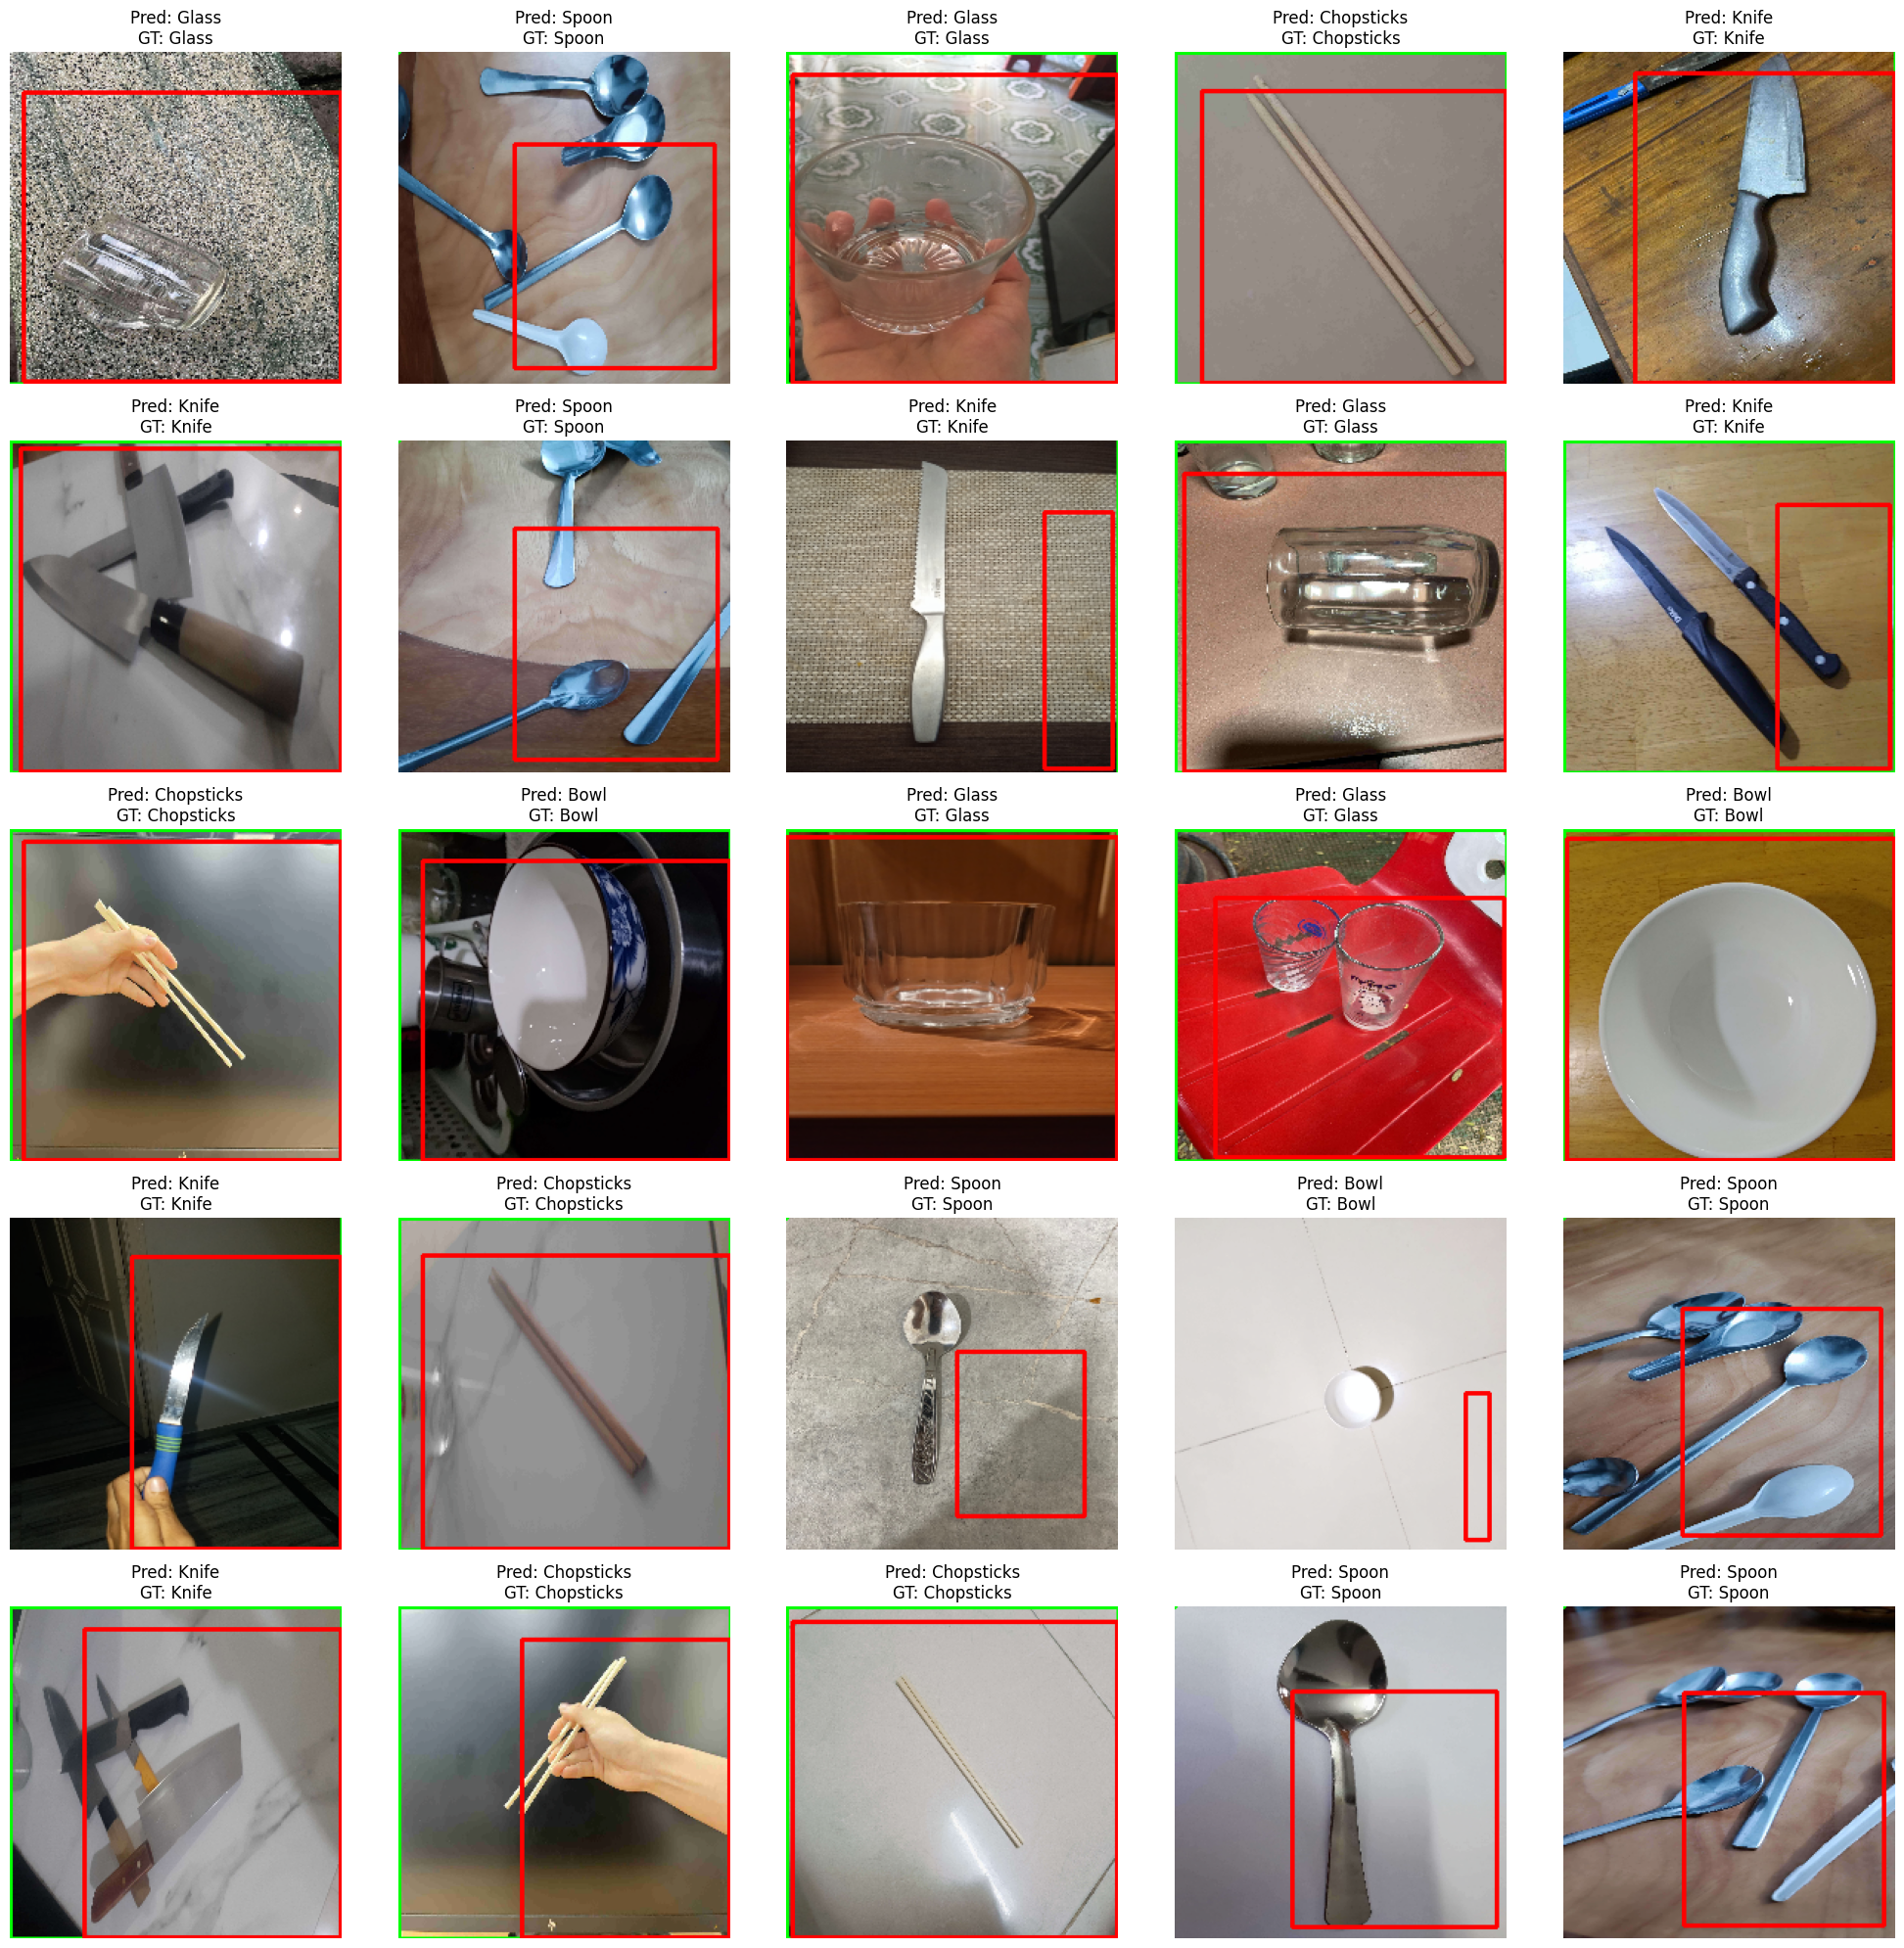

Quá trình huấn luyện và đánh giá đã hoàn tất.
Các biểu đồ trực quan đã được lưu vào thư mục: /content/drive/MyDrive/BBox/plots/


In [20]:
def main():
    """Hàm chính để chạy toàn bộ quy trình."""
    # Siêu tham số
    base_dir = '/content/drive/MyDrive/BBox'
    img_size = 224
    batch_size = 32
    num_epochs = 500

    # Tạo file data.yaml
    create_data_yaml(base_dir)

    # Load dữ liệu
    train_loader, val_loader, test_loader, label_encoder = get_data_loaders(base_dir, batch_size, img_size)

    # Khởi tạo mô hình
    model = ResNet18TwoBranch(num_classes=6).to(device)
    pretrained_dict = torch.load(os.path.join(base_dir, '/content/drive/MyDrive/bestmodel/resnet18_best_model.pth'))
    model_dict = model.state_dict()

    # Lọc các trọng số phù hợp, chỉ lấy các trọng số của phần feature extractor, bỏ qua các lớp fully connected
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}

    # Cập nhật trọng số của mô hình
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    # Huấn luyện mô hình và lưu metrics
    train_losses, val_losses, train_accs, val_accs, train_ious, val_ious = train_model(model, train_loader, val_loader, num_epochs, img_size, base_dir)

    # Vẽ biểu đồ tổng hợp cuối cùng
    plot_training_metrics(train_losses, val_losses, train_accs, val_accs, train_ious, val_ious,
                         train_losses[-len(train_losses):], train_losses[-len(train_losses):],
                         len(train_losses), base_dir)

    # Đánh giá
    evaluate_model(model, test_loader, label_encoder, img_size, base_dir)

    # Lưu mô hình
    torch.save(model, os.path.join(base_dir, 'model.pth'))

    print("Quá trình huấn luyện và đánh giá đã hoàn tất.")
    print(f"Các biểu đồ trực quan đã được lưu vào thư mục: {base_dir}/plots/")

if __name__ == "__main__":
    main()